# Fig. 4 G: Tracks of the centrosome
In this notebook we plot the tracks of the centrosome and visualise them on a polar histogram.

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import statannot
from scipy.stats import mannwhitneyu
from astropy.stats import circvar

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degree between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) / 2 / np.pi * 360

def angle_between_arrays(a1, a2):
    angles = []
    for i in range(a1.shape[0]):
        v1 = a1[i,:]
        v2 = a2[i,:]
        angles.append(angle_between(v1, v2))
    return np.array(angles)

def listFiles(root): # listdir
    allFiles = []; walk = [root]
    while walk:
        folder = walk.pop(0)+"/"; items = os.listdir(folder) # items = folders + files
        for i in items: i=folder+i; (walk if os.path.isdir(i) else allFiles).append(i)
    return allFiles

def round_to_point_five(x):
    return np.round(x * 2) / 2

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [4]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, color='b'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n / (0.001 + len(x)) *40

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='w', fill=True, linewidth=1, bottom=15, color=color)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

## Assemble dataframe
In the next few cells, we will read in the imaris tracking files and assemble them into one dataframe.

In [5]:
main_path = 'data/3D_centrosome_tracking_wt/tracking_data/'
sample_paths = os.listdir(main_path)
tracks = []
for sample in sample_paths:
    if sample[0] == '.':
        continue
    kmid = sample.split('_')[0]
    if 'Cell' in sample.split('_')[1]:
        cell_number = sample.split('_')[1][-1]
        organelle_type = sample.split('_')[2].lower()
    elif 'Cell' in sample.split('_')[2]:
        cell_number = sample.split('_')[2][-1]
        organelle_type = sample.split('_')[3].lower()
    sid = kmid + 'c' + cell_number
    track_file = os.path.join(main_path, sample, sample[:-10] + 'Position.csv')
    track = pd.read_csv(track_file, skiprows=3).drop(['Unit', 'Category', 'Collection', 'Unnamed: 9'], axis=1).rename({'Position X': 'x', 'Position Y': 'y', 'Position Z': 'z', 'Time': 'time', 'TrackID': 'track id', 'ID': 'id'}, axis=1)
    track['cell number'] = cell_number
    track['km id'] = kmid
    track['sample id'] = sid
    if organelle_type == 'cell-soma':
        track['type'] = 'cell-body'
    elif organelle_type == 'phagosomes':
        track['type'] = 'phagosome success'
    elif organelle_type == 'failed-events':
        track['type'] = 'phagosome failure'
    else:
        track['type'] = organelle_type
    tracks.append(track)
all_tracks = pd.concat(tracks)
all_tracks['track id'] -= 1E9
all_tracks.to_csv('all_tracks.csv')

Next we categorise the engulfment mode using the file `Cell-body_events.csv`, in which cell body events have been identified manually.

In [6]:
all_tracks['engulfment mode'] = 'branch'

cell_body_events = pd.read_csv('data/3D_centrosome_tracking_wt/Cell-body_events.csv')

for i in cell_body_events.index:
    row = cell_body_events.iloc[i]
    kmid = row['Cell ID'].split('_')[0]
    cell_number = str(row['Cell ID'].split('_')[1][-1])
    tid = row['Track ID'] - 1E9
    all_tracks.loc[(all_tracks['km id'] == kmid) & 
                   (all_tracks['cell number'] == cell_number) & 
                   (all_tracks['track id'] == tid), 'engulfment mode'] = 'cell body'
all_tracks
    

,x,y,z,time,track id,id,cell number,km id,sample id,type,engulfment mode
0,36.6216,32.6064,25.8510,1,17505.0,17505,4,km122,km122c4,centrosome,branch
1,37.5169,33.1500,26.2460,2,17505.0,53972,4,km122,km122c4,centrosome,branch
2,38.3200,33.5170,26.3590,3,17505.0,91150,4,km122,km122c4,centrosome,branch
3,38.2274,33.8626,26.2151,4,17505.0,128784,4,km122,km122c4,centrosome,branch
4,37.9521,33.0346,26.2613,5,17505.0,166638,4,km122,km122c4,centrosome,branch
...,...,...,...,...,...,...,...,...,...,...,...
291,23.0178,18.9255,28.9252,376,496.0,503,1,km133,km133c1,phagosome success,cell body
292,23.1164,19.0185,28.4323,377,496.0,504,1,km133,km133c1,phagosome success,cell body
293,22.8657,19.5765,27.6035,378,496.0,505,1,km133,km133c1,phagosome success,cell body
294,22.8867,19.4835,27.0036,379,496.0,506,1,km133,km133c1,phagosome success,cell body


In [7]:
rename_dict = {'x': 'x [µm]',
               'y': 'y [µm]',
               'z': 'z [µm]',
               'time': 'frame',
               'cell number': 'cell',
               'sample id': 'cell id',
               'km id': 'sample id'}

In [8]:
raw = all_tracks.rename(rename_dict, axis=1)
raw['time [min]'] = raw['frame'] * 1/3
raw['condition'] = 'wt'

In [9]:
df_list = []
for sid in raw['cell id'].unique():
    # cell body + auxilary info
    sdf = raw.loc[raw['cell id'] == sid].copy()
    ndf = sdf.loc[sdf['type'] == 'cell-body'].copy()
    ndf['phagocytic mode'] = None
    ndf.rename({'x [µm]': 'cell body x [µm]',
                'y [µm]': 'cell body y [µm]',
                'z [µm]': 'cell body z [µm]'},
               inplace=True,
               axis=1)
    ndf.drop(['file', 'x [px]', 'y [px]', 'track no', 'point no', 'frame', 'engulfment mode'],
             inplace=True,
             errors='ignore',
             axis=1)
    # centrosome
    adf = sdf.loc[sdf['type'] == 'centrosome', ['x [µm]', 'y [µm]', 'z [µm]', 'time [min]']].copy()
    ndf = ndf.merge(adf,
                  on=['time [min]'], how='inner').drop_duplicates()
    ndf.rename({'x [µm]': 'centrosome x [µm]',
                'y [µm]': 'centrosome y [µm]',
                'z [µm]': 'centrosome z [µm]'},
                inplace=True,
                axis=1)
    # phagosome
    adf = sdf.loc[sdf['type'].str.contains('phagosome'), ['x [µm]', 'y [µm]', 'z [µm]', 'time [min]', 'track id', 'type', 'engulfment mode']].copy()
    _l = []
    for tid in adf['track id'].unique():
        if np.isnan(tid):
            continue
        _l.append(adf.loc[adf['track id']==tid].iloc[0])
    adf = pd.concat(_l, axis=1).T
    adf['phagocytic mode'] = adf['type'].str.replace('phagosome ', '')
    adf.drop('type', inplace=True, axis=1)
    ndf = ndf.merge(adf,
                  on=['time [min]'], how='outer', suffixes=['_del', ''])
    ndf.rename({'x [µm]': 'phagosome x [µm]',
                'y [µm]': 'phagosome y [µm]',
                'z [µm]': 'phagosome z [µm]'},
                inplace=True,
                axis=1)
    ndf.drop('phagocytic mode_del', inplace=True, axis=1)

    df_list.append(ndf)
df = pd.concat(df_list)


## Define phagocytosis events

Now we generate 'phagocytic event windwos' that are the time points a cell is busy with a specific phagocytic event. Phagocytic event windows contain only one phagocytic event and are maximum -/+ 5min wide (10min total). If consecutive phagocytic events are closer than 10min, we trim their windows equidistantly, i.e. we change from one to the other in the temporal centre between them (for practical reasons, we overlap touching windows by one frame to avoid windows with width 0).

In [10]:
phago_window_width = 10 # min
event_list = []
for cid in df['cell id'].unique():
    sdf = df.loc[(df['cell id'] == cid)].copy()
    tp_p = sdf.loc[sdf['phagocytic mode'].notna(),['time [min]']].to_numpy().flatten()
    tp_p_pad = np.array([sdf['time [min]'].min()] + list(tp_p) + [sdf['time [min]'].max()])
    distance_between_events = tp_p_pad[1:] - tp_p_pad[:-1]

    event_cutoffs = round_to_point_five(np.clip(distance_between_events, 1, phago_window_width) / 2)
    for i, phago_event_tp in enumerate(tp_p):
        bound_low = phago_event_tp - event_cutoffs[i]
        bound_high = phago_event_tp + event_cutoffs[i+1]
        ssdf = sdf.loc[(sdf['time [min]'] >= bound_low) & (sdf['time [min]'] <= bound_high)].copy() 
        ssdf['event id'] = str(cid) + '_e{:03d}'.format(i)
        ssdf['phagocytic mode'] = ssdf['phagocytic mode'].dropna().values[0]
        #phago_time = np.linspace(-int(event_cutoffs[i]), int(event_cutoffs[i+1], len(ssdf.index)))
        #phago_time = np.arange(-event_cutoffs[i], event_cutoffs[i+1] + .5, .5)
        
        ssdf['time event [min]'] = ssdf['time [min]'] - phago_event_tp
        event_list.append(ssdf)
events = pd.concat(event_list)
    


In [11]:
event_list = []
err_count = 0
for evid in events['event id'].unique():
    try:
        sdf = events.loc[events['event id'] == evid].copy()
        centrosome = sdf[['centrosome x [µm]', 'centrosome y [µm]']].to_numpy().astype(float)
        cell_body = sdf[['cell body x [µm]', 'cell body y [µm]']].to_numpy().astype(float)
        phagosome = sdf[['phagosome x [µm]', 'phagosome y [µm]']].dropna().to_numpy()[0,:].astype(float)

        sdf['distance cb-cs [µm]'] = (np.linalg.norm(cell_body - centrosome, axis= 1))
        sdf['distance cb-p [µm]'] = (np.linalg.norm(cell_body - phagosome, axis= 1))
        sdf['distance cs-p [µm]'] = (np.linalg.norm(centrosome - phagosome, axis= 1))

        sdf['angle cb-cs'] = angle_between_arrays(cell_body - phagosome, centrosome - phagosome)
        sdf['angle cb-p'] = angle_between_arrays(cell_body - centrosome, phagosome - centrosome)
        sdf['angle cs-p'] = angle_between_arrays(centrosome - cell_body, phagosome - cell_body)
        #print(sdf[['event tp', 'angle cb-cs', 'angle cb-p', 'angle cs-p']])

        

        event_list.append(sdf)
    except ValueError:
        err_count += 1
events = pd.concat(event_list)
print('Number of errors when calculating distances and angles: {}'.format(err_count))

Number of errors when calculating distances and angles: 0


In [12]:
for evid in events['event id'].unique():
    _sdf = events.loc[events['event id']==evid]
    emu = _sdf['engulfment mode'].unique()
    for x in emu:
        if type(x)==str:
            em = x
    pm = _sdf['phagocytic mode'].unique()[0]
    events.loc[events['event id']==evid, 'mode'] = pm + ' ' + em

In [13]:
events['success'] = events['mode'].str.contains('success')

## Fig. 4 G: Polar plot of centrosome tracks and cicular histogram

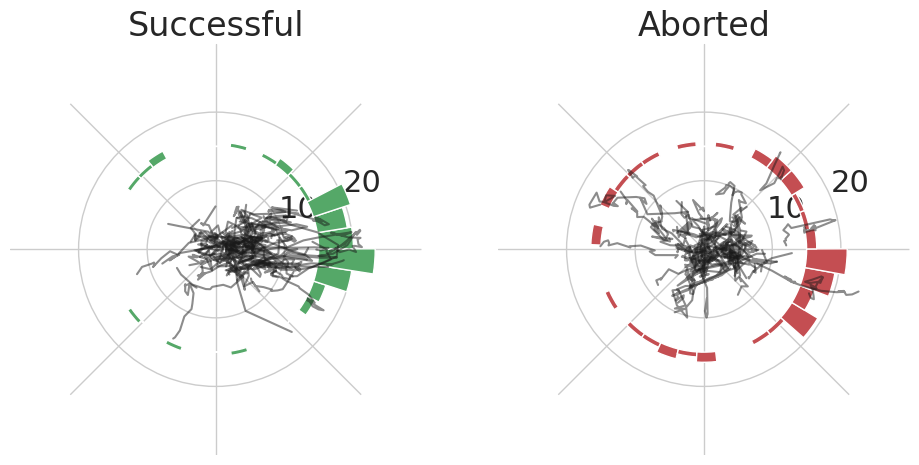

In [15]:
fig = plt.figure(figsize=(15,5))
sns.set(font_scale=2, style='whitegrid', rc={'figure.dpi':100})
i = 0

for success in [True, False]:
    if success:
        color = 'g'
        mode = 'Successful'
    else:
        color = 'r'
        mode = 'Aborted'
    i+=1
    ax = plt.subplot(1,3, i, projection='polar')
    ax.set_title(mode)
    ax.set_xticklabels([])
    ax.set_yticks([10,20])
    ax.set_ylim(0,30)
    ax.spines['polar'].set_visible(False)
    sevents = events.loc[(events['condition'] == 'wt') & (events['success']==success)]
    rs = []
    phis = []
    for evid in sevents['event id'].unique():
        sdf = sevents.loc[sevents['event id'] == evid].copy()
        if len(sdf.index) == 0:
            continue
        sdf.reset_index(inplace=True, drop=True)
        try:
            c_idx = sdf.loc[sdf['time event [min]']==1].index[0]
        except IndexError:
            c_idx = sdf.loc[sdf['time event [min]']==0].index[0]
        x = sdf['centrosome x [µm]'].values - sdf['cell body x [µm]'].values
        y = sdf['centrosome y [µm]'].values - sdf['cell body y [µm]'].values
        r, phi = cart2pol(x,y)
        xp = sdf['phagosome x [µm]'].dropna().values[0] - sdf['cell body x [µm]'].values
        yp = sdf['phagosome y [µm]'].dropna().values[0] - sdf['cell body y [µm]'].values
        rp, phip = cart2pol(xp,yp)
        phi -= phip
        rs.append(r[c_idx])
        phis.append(phi[c_idx])
        ax.plot(phi, r, 'k', alpha=.5)
    circular_hist(ax, np.array(phis), density=False, bins=32, color=color)

plt.tight_layout()
plt.savefig('plots/Fig4G.png')